# Plot example data for a single patient

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
%matplotlib inline

In [2]:
# Config
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'public,mimiciii'

# append the search path to the beginning of each query
query_schema = 'set search_path to ' + schema_name + ';'

In [3]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [4]:
# Load angus
query = query_schema + """
-- get first icu stay for adult patients
with t1 as 
(
select ie.icustay_id, ie.hadm_id, ie.intime, ie.outtime
, ROW_NUMBER() over (partition by ie.subject_id order by ie.intime) as icustay_num
from icustays ie
inner join admissions adm
on ie.hadm_id = adm.hadm_id
-- adult patient
inner join patients pat
on ie.subject_id = pat.subject_id
and ie.intime > pat.dob + interval '1' year
)
SELECT t1.hadm_id
, si.suspected_infection_time
, si.positiveculture as positive_culture
, so.sofa
, case when si.suspected_infection_time is not null
    and so.sofa >= 2
        then 1
    else 0
end as sepsis3
, ms.sepsis as martin
, ang.angus
, es.sepsis as explicit_sepsis
FROM t1
left join sepsis3_cohort si
    on t1.icustay_id = si.icustay_id
left join sofa so
    on t1.icustay_id = so.icustay_id
left join angus_sepsis ang
    on t1.hadm_id = ang.hadm_id
left join martin_sepsis ms
    on t1.hadm_id = ms.hadm_id
left join explicit_sepsis es
    on t1.hadm_id = es.hadm_id
where t1.icustay_num = 1
"""
df = pd.read_sql_query(query,con)

In [5]:
print('{:5g} first ICU stay for adults.'.format(
        df['hadm_id'].count()))
print('{:5g} with suspected sepsis (blood culture within 24 hours of admission)'.format(
        df['suspected_infection_time'].count()))
print('{:5g} with a positive blood culture'.format(
    df['positive_culture'].sum()))
print('{:5g} with Angus'.format(
    df['angus'].sum()))
print('{:5g} with Angus and suspected sepsis'.format(
    ((df['angus']==1)&(~df['suspected_infection_time'].isnull())).sum()))
print('{:5g} with Martin'.format(
    df['martin'].sum()))
print('{:5g} with Martin and suspected sepsis'.format(
    ((df['martin']==1)&(~df['suspected_infection_time'].isnull())).sum()))

38606 first ICU stay for adults.
26399 with suspected sepsis (blood culture within 24 hours of admission)
 3475 with a positive blood culture
10575 with Angus
 9201 with Angus and suspected sepsis
 5249 with Martin
 4841 with Martin and suspected sepsis


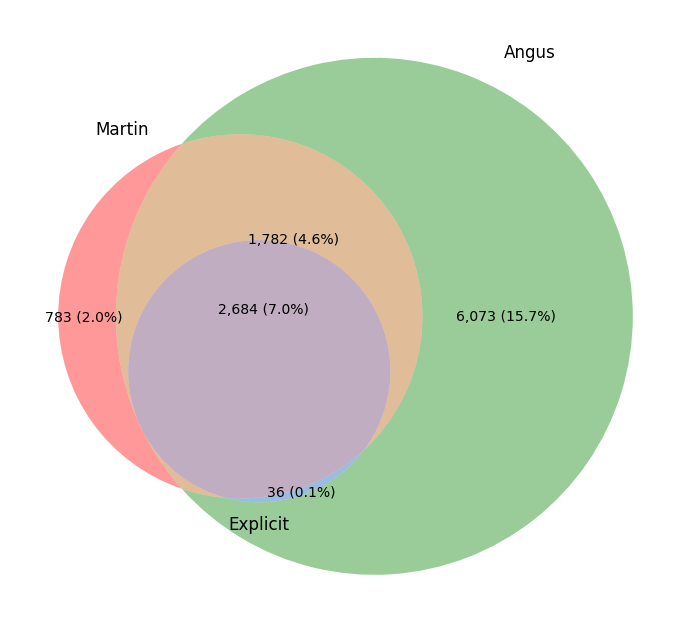

In [10]:
# venn diagram with matplotlib-venn
from matplotlib_venn import venn3

idx = df['martin']==1
set1 = set(df.loc[idx,'hadm_id'])
idx = df['angus']==1
set2 = set(df.loc[idx,'hadm_id'])
idx = df['explicit_sepsis']==1
set3 = set(df.loc[idx,'hadm_id'])

plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 14})
venn3([set1, set2, set3], ('Martin', 'Angus', 'Explicit'),
      subset_label_formatter=lambda x: '{:,} ({:2.1f}%)'.format(x, x*100.0/df.shape[0]))
plt.show()

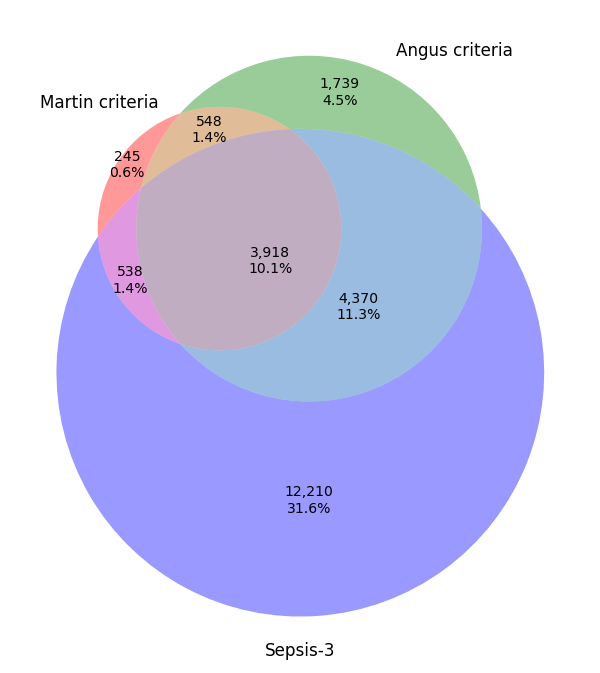

In [22]:
# venn diagram with matplotlib-venn
from matplotlib_venn import venn3

idx = df['martin']==1
set1 = set(df.loc[idx,'hadm_id'])
idx = df['angus']==1
set2 = set(df.loc[idx,'hadm_id'])
idx = df['sepsis3']==1
set3 = set(df.loc[idx,'hadm_id'])

plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 14})
venn3([set1, set2, set3], ('Martin criteria', 'Angus criteria', 'Sepsis-3'),
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.show()

In [23]:
con.close()